# Gradient Boosting from (Almost) Scratch

### By John Clements

Over the past month, I've been slowly working my way through Joel Grus' Data Science from Scratch 2nd Edition and I have thoroughly enjoyed building simple versions of machine learning algorithms. I've always learned better by doing and this book plays to that learning style. Unfortunately, it doesn't have a chapter for implementing gradient boosting. Although I read through Tianqi Chen's great slides (https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf), I thought I'd gain a better understanding of gradient boosting by implementing it myself.

Gradient boosting is a relatively simple algorithm. It works by training weak models (most frequently CARTs) on the residuals from the preceding iteration. New predictions are generated by adding the predicted residuals multiplied by a learning rate between 0 and 1 to the previous prediction. The learning rate prevents the model from taking too large a step towards the actual values and overshooting them. Small learning rates take longer to converge towards the best fit. Finding the right one is a balancing act. I highly recommend Tianqi Chen's slides for a more thorough treatment of gradient boosting, or look at the documentation for XGBoost, which is his amazing gradient boosting package (https://xgboost.readthedocs.io/en/latest/index.html).

I said gradient boosting from almost scratch; I use scikit-learn's models as my weak learners and use numpy for its efficiency for certain mathematical functions and for its array structure.

The gradient boosting algorithm goes:

# **Step 1: Make a first guess for the training and testing y, using the average of the training y**
## $y_{train_{pred_0}} = \frac{1}{n} * \Sigma_{i = 1}^{n}y_{train_i}$

## $y_{test_{pred_0}} = y_{train_{pred_0}}$

# **Step 2: Calculate the residuals from the training data set**
## $r_0 = y_{train} - y_{train_{pred_0}}$

# **Step 3: Fit a weak learner to the residuals minimizing the loss function**
## $r_0 = f_0(X_{train})$, such that

## $f_0(X) = arg_{h(X)}min(\Lambda(r_0, h(X_{train}))$ 

### Here $\Lambda$ is our loss function and $h(X)$ is a weak learner trained on the explanatory variables and residuals from the preceding step. 

### The first model I am using is scikit-learn's regression tree. Therefore the potential loss functions are Mean Squared Error, Friedman's adjusted Mean Square Error, and Mean Absolute Error. They each contain regularization terms, which is lucky for me. A more thorough explanation of each is contained in the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html.

### In addition, I am using a ridge regression model whose loss function is the sum of the squared errors + the l2 norm of the coefficients multiplied by a penalty coefficient. More information is here: https://en.wikipedia.org/wiki/Tikhonov_regularization

# **Step 4: Increment the predicted y's**
## $y_{train_{pred_1}} = y_{train_{pred_0}} + learning rate * f_0(X_{train})$

## $y_{test_{pred_1}} = y_{test_{pred_0}} + learning rate * f_0(X_{test})$

# **Step 5: Repeat Steps 2 through 4 until you reach the number of boosting rounds**

### Calculate the residuals using $y_{train_{pred_1}}$, fit a new model, increment the predictions, and repeat for $2, 3, ..., n$, where $n$ is the number of boosting iterations.

This algorithm is implemented below.

In [1]:
import typing
import numpy as np
def GradBoost(model,
              X_test: np.array,                  # testing independent variables
              X_train: np.array,                 # training independent variables
              y_train: np.array,                 # training dependent variable
              boosting_rounds: int = 100,        # number of boosting rounds
              learning_rate: float = 0.1,        # learning rate with default of 0.1
              verbose: bool = True) -> np.array: # if True, shows a tqdm progress bar
    '''
    Takes in a model and performs gradient boosting using that model. This allows for almost any scikit-learn
    model to be used.
    '''
    import numpy as np
    from tqdm import tqdm_notebook as tqdm
    
    # make a first guess of our training target variable using the mean
    y_hat_train = np.repeat(np.mean(y_train), len(y_train))
    # initialize the out of sample prediction with the mean of the training target variable
    y_hat_train_test = np.repeat(np.mean(y_train), len(X_test))
    # calculate the residuals from the training data using the first guess
    pseudo_resids = y_train - y_hat_train
    
    # performs gradient boosting with a tqdm progress bar
    if verbose:
        # iterates through the boosting round
        for _ in tqdm(range(0, boosting_rounds)):
            # fit the model to the pseudo residuals
            model = model.fit(X_train, pseudo_resids)   
            # increment the predicted training y with the pseudo residual * learning rate
            y_hat_train += learning_rate * model.predict(X_train)       
            # increment the predicted test y as well
            y_hat_train_test += learning_rate * model.predict(X_test)
            # calculate the pseudo resids for next round
            pseudo_resids = y_train - y_hat_train 
    # performs gradient boosting without a progress bar        
    else:
        # iterates through the boosting round
        for _ in range(0, boosting_rounds):
            # fit the model to the pseudo residuals
            model = model.fit(X_train, pseudo_resids)   
            # increment the predicted training y with the pseudo residual * learning rate
            y_hat_train += learning_rate * model.predict(X_train)       
            # increment the predicted test y as well
            y_hat_train_test += learning_rate * model.predict(X_test)
            # calculate the pseudo resids for next round
            pseudo_resids = y_train - y_hat_train  

    # return a tuple of the predicted training y and the predicted test y
    return y_hat_train, y_hat_train_test

Now let's generate some testing data to see if this function works. I chose to simulate data, so I know there is a relationship between the some of the independent variables and the target variable. I used scikit-learn's make_regression function to generate 1,000 observations, with 20 independent variables, three-quarters of which actually contain useful information. I then split the data into training and testing data sets.

In [2]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, 
                       n_features=20, 
                       n_informative=15, 
                       n_targets=1, 
                       bias=0.0, 
                       noise=20,
                       shuffle=True,
                       random_state=13)

X_train = X[0:int(len(X) / 2)]
y_train = y[0:int(len(X) / 2)]

X_test = X[int(len(X) / 2):]
y_test = y[int(len(X) / 2):]

When using gradient boosting, too few iterations leads to an underfit model and too many iterations leads to an overfitted one. Before we make predictions, it is helpful to see how the training mean square error evolves with more boosting iterations, so we can try and fit a well calibrated model.

When actually attempting to solve a real problem, you would determine the number of boosting rounds, as well as other parameters, using a grid search and k-folds cross validation. I did something a little simpler, for ease of demonstration. I just plotted the training Mean Square Error vs. number of boosting rounds for 5 to 500 rounds, incrementing by 5 and chose a semi-arbitrary cut-off. 

The regression trees in this implementation have depth of 3 and the loss function is specified as the regularized mean square error. The learning rate is set to 0.01. The ridge regressions choose the best l2-norm penalty coefficient at each step among {0.01, 0.1, 1, 10} using 3-fold cross validation.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

tree_model = DecisionTreeRegressor(criterion='mse',
                                   max_depth=3)
ridge_model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), 
                      fit_intercept=True, 
                      normalize=True,
                      cv=3)
###
# Plot the training mean squared error vs. number of boosting rounds by looping through various
# numbers of boosting rounds, calculating the training mean squared error each round and 
# appending it to a list.
###
from tqdm import tqdm_notebook as tqdm
tree_mse_train = []
n_rounds = np.arange(5, 501, 5)
for n_round in tqdm(n_rounds):
    y_hat_train = GradBoost(tree_model,
                            X_test,
                            X_train,   
                            y_train,  
                            boosting_rounds=n_round,  
                            learning_rate=0.01,
                            verbose=False)[0]
    
    tree_mse_train.append(np.mean((y_train - y_hat_train) ** 2))


ridge_mse_train = []
for n_round in tqdm(n_rounds):
    y_hat_train = GradBoost(ridge_model,
                            X_test,
                            X_train,   
                            y_train,  
                            boosting_rounds=n_round,  
                            learning_rate=0.01,
                            verbose=False)[0]
    
    ridge_mse_train.append(np.mean((y_train - y_hat_train) ** 2))

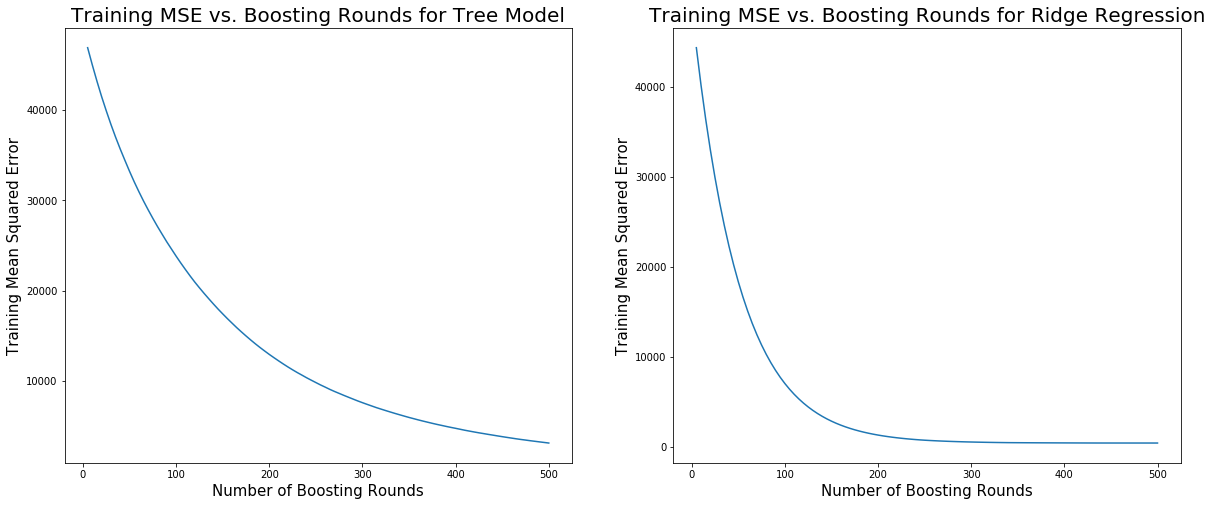

In [11]:
# sets the plot size to 20x8
plt.rcParams['figure.figsize'] = (20,8)

plt.subplot(1, 2, 1)
plt.plot(n_rounds, tree_mse_train)
plt.title('Training MSE vs. Boosting Rounds for Tree Model', fontsize=20)
plt.xlabel('Number of Boosting Rounds', fontsize=15)
plt.ylabel('Training Mean Squared Error', fontsize=15)
plt.show;

# sets the plot size to 20x8
plt.rcParams['figure.figsize'] = (20,8)

plt.subplot(1, 2, 2)
plt.plot(n_rounds, ridge_mse_train)
plt.title('Training MSE vs. Boosting Rounds for Ridge Regression', fontsize=20)
plt.xlabel('Number of Boosting Rounds', fontsize=15)
plt.ylabel('Training Mean Squared Error', fontsize=15)
plt.show;

When using the trees as our weak learner, the mean squared error falls quickly until it reaches an inflection point around 150 boosting iterations. After that point, it gently slopes down as it approaches 500 rounds. When using the ridge regression model, the training mean square error plunges until 125ish and it really levels off after 250. We'll use 500 as our number of boosting iterations using trees and 250 for the ridge regression boosting model. But first, let's look at the results from 0 and 50 boosting iterations.

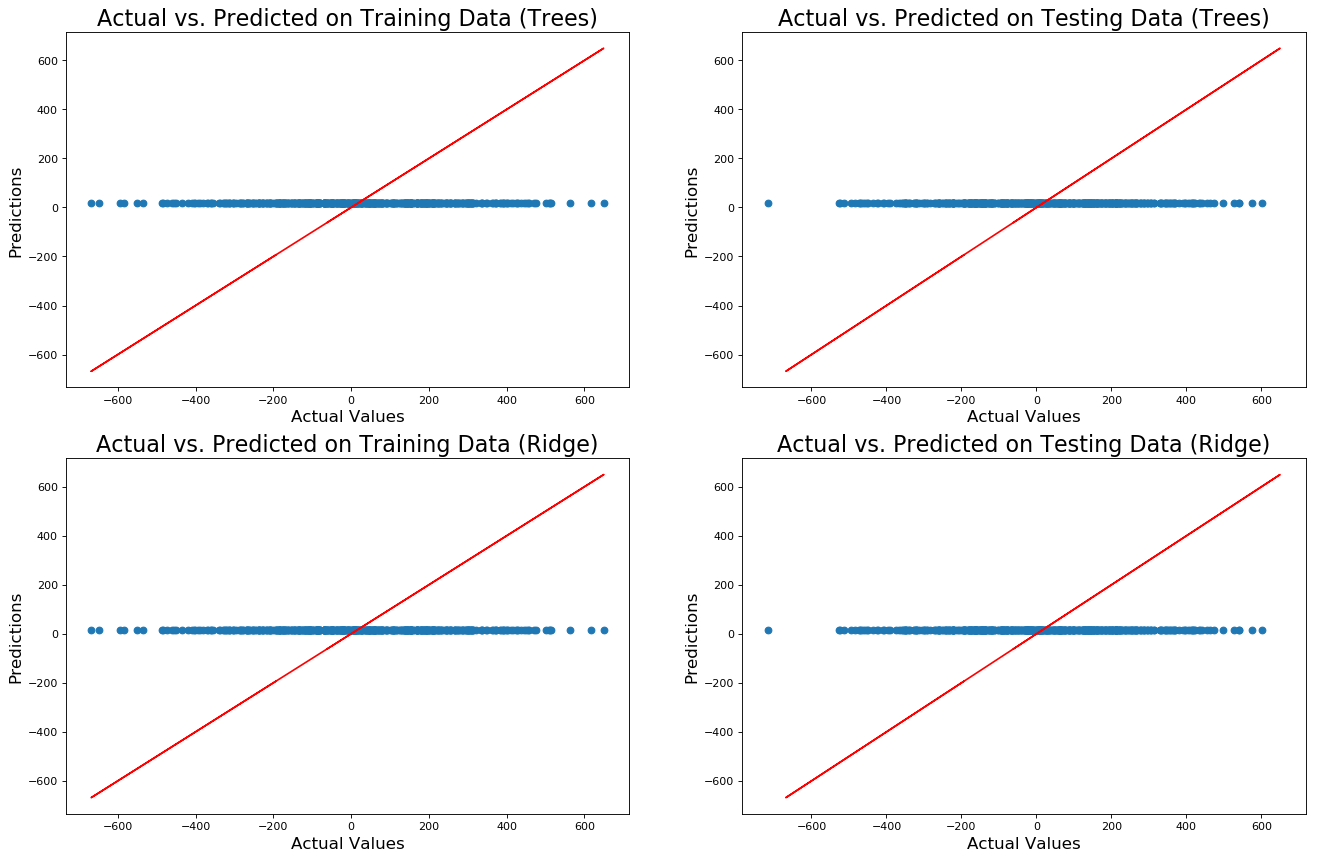

In [4]:
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')

n_rounds = 0

y_hat_train, y_hat_test = GradBoost(tree_model,
                                    X_test,
                                    X_train,   
                                    y_train,  
                                    boosting_rounds=n_rounds,  
                                    learning_rate=0.01,
                                    verbose=False)

plt.subplot(321)
plt.scatter(y_train, y_hat_train)
plt.title('Actual vs. Predicted on Training Data (Trees)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')

plt.subplot(322)
plt.scatter(y_test, y_hat_test)
plt.title('Actual vs. Predicted on Testing Data (Trees)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')
plt.show;

y_hat_train, y_hat_test = GradBoost(ridge_model,
                                    X_test,
                                    X_train,   
                                    y_train,  
                                    boosting_rounds=n_rounds, 
                                    learning_rate=0.01,
                                    verbose=False)

# sets the plot size to 20x8
plt.rcParams['figure.figsize'] = (20,20)

plt.subplot(323)
plt.scatter(y_train, y_hat_train)
plt.title('Actual vs. Predicted on Training Data (Ridge)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')

plt.subplot(324)
plt.scatter(y_test, y_hat_test)
plt.title('Actual vs. Predicted on Testing Data (Ridge)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')
plt.show;

In the plots above, the red line is where the predicted values equal the actual values. The closer to that line for the testing data, the more accurate our model. If the training predictions are a tight fit, but the testing predictions are all over the place, the model is overfit to the training data.

With 0 boosting rounds, we are just guessing the average. As you would expect, this naive "model" underfits the data. Let's see how things evolve after 50 boosting rounds.

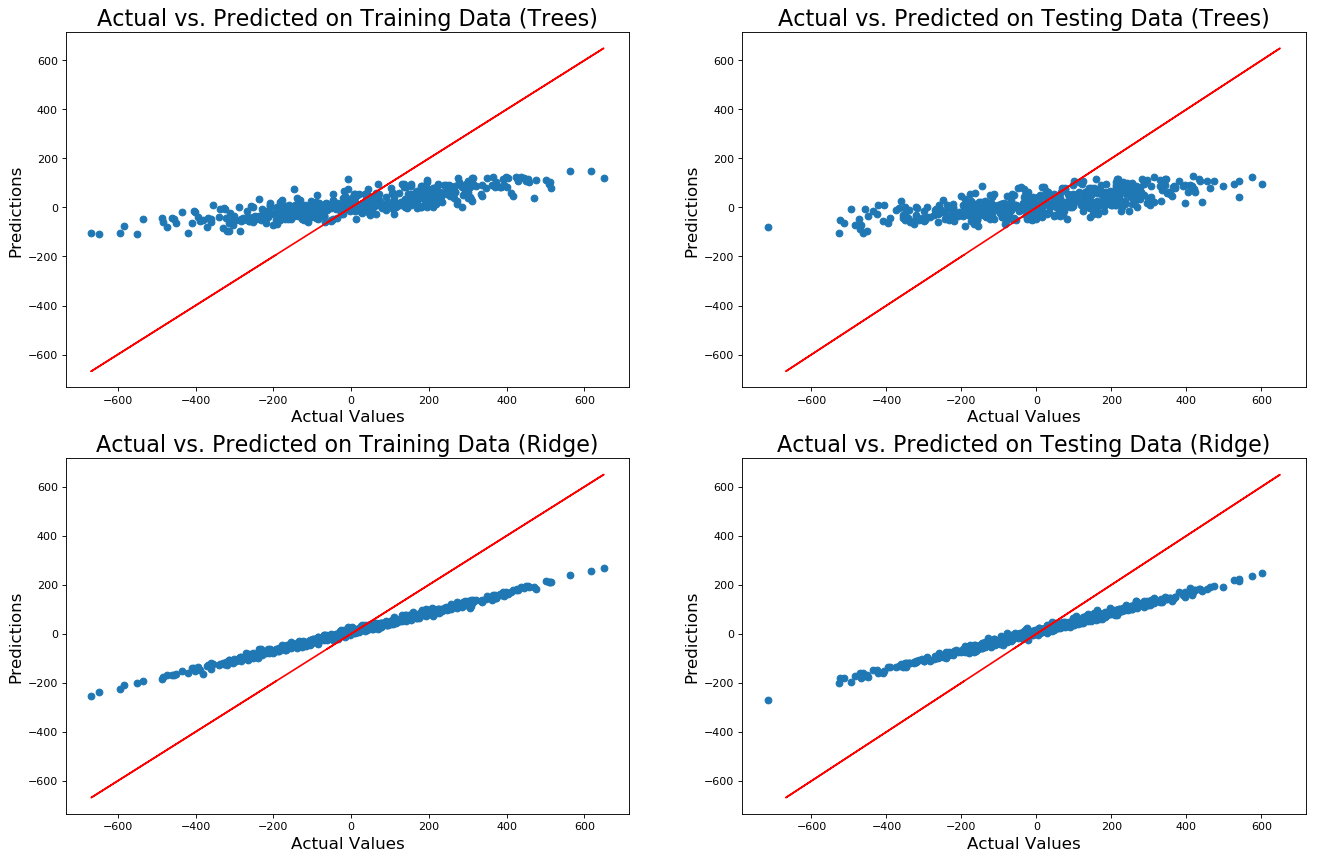

In [5]:
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')

n_rounds = 50

y_hat_train, y_hat_test = GradBoost(tree_model,
                                    X_test,
                                    X_train,   
                                    y_train,  
                                    boosting_rounds=n_rounds,  
                                    learning_rate=0.01,
                                    verbose=False)

plt.subplot(321)
plt.scatter(y_train, y_hat_train)
plt.title('Actual vs. Predicted on Training Data (Trees)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')

plt.subplot(322)
plt.scatter(y_test, y_hat_test)
plt.title('Actual vs. Predicted on Testing Data (Trees)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')
plt.show;

y_hat_train, y_hat_test = GradBoost(ridge_model,
                                    X_test,
                                    X_train,   
                                    y_train,  
                                    boosting_rounds=n_rounds, 
                                    learning_rate=0.01,
                                    verbose=False)

# sets the plot size to 20x8
plt.rcParams['figure.figsize'] = (20,20)

plt.subplot(323)
plt.scatter(y_train, y_hat_train)
plt.title('Actual vs. Predicted on Training Data (Ridge)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')

plt.subplot(324)
plt.scatter(y_test, y_hat_test)
plt.title('Actual vs. Predicted on Testing Data (Ridge)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')
plt.show;

At 50 rounds, the predictions from each model are starting to rotate towards the perfect prediction line. The cloud of predictions is much tighter for the model using ridge regression as the weak learner. This is probably because the data we generated contains linear relationships and ridge regression is a linear model. Now I think it is time to make our final predictions and compare.

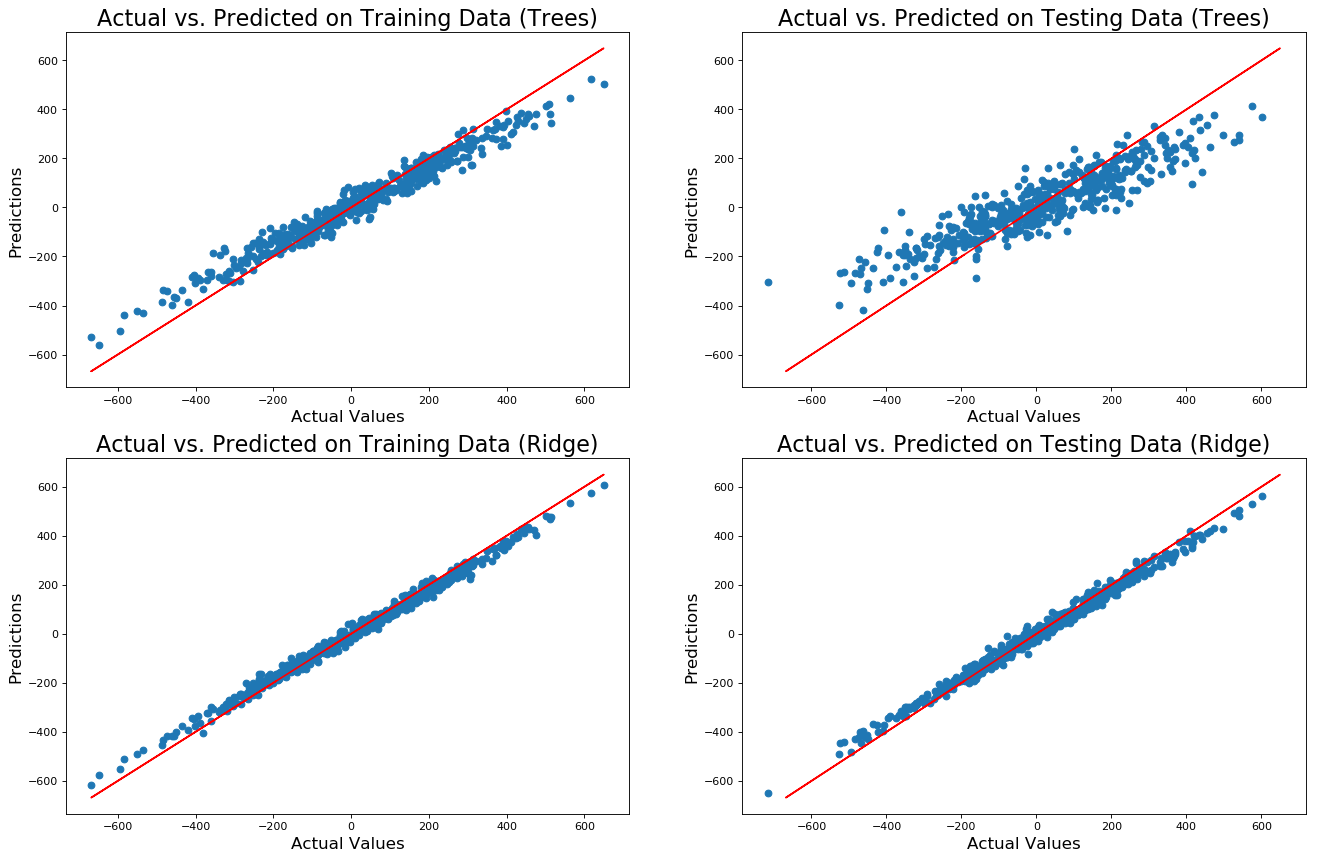

In [6]:
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')

y_hat_train_tree, y_hat_test_tree = GradBoost(tree_model,
                                              X_test,
                                              X_train,   
                                              y_train,  
                                              boosting_rounds=500, 
                                              learning_rate=0.01,
                                              verbose=True)

plt.subplot(321)
plt.scatter(y_train, y_hat_train_tree)
plt.title('Actual vs. Predicted on Training Data (Trees)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')

plt.subplot(322)
plt.scatter(y_test, y_hat_test_tree)
plt.title('Actual vs. Predicted on Testing Data (Trees)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')
plt.show;

y_hat_train_ridge, y_hat_test_ridge = GradBoost(ridge_model,
                                                X_test,
                                                X_train,
                                                y_train,  
                                                boosting_rounds=250, 
                                                learning_rate=0.01,
                                                verbose=True)

# sets the plot size to 20x8
plt.rcParams['figure.figsize'] = (20,20)

plt.subplot(323)
plt.scatter(y_train, y_hat_train_ridge)
plt.title('Actual vs. Predicted on Training Data (Ridge)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')

plt.subplot(324)
plt.scatter(y_test, y_hat_test_ridge)
plt.title('Actual vs. Predicted on Testing Data (Ridge)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')
plt.show;

At 500 iterations, our boosted trees model is decent, but it performs worse the farther from the mean of the target variable. Still it is a much better fit than the 50 round model. Our model with ridge regression as the weak learner is a much better fit. Again, this is likely due to the linear structure in the simulated data. Speaking of linear structure, let's check how these models fare against a simple multiple linear regression.

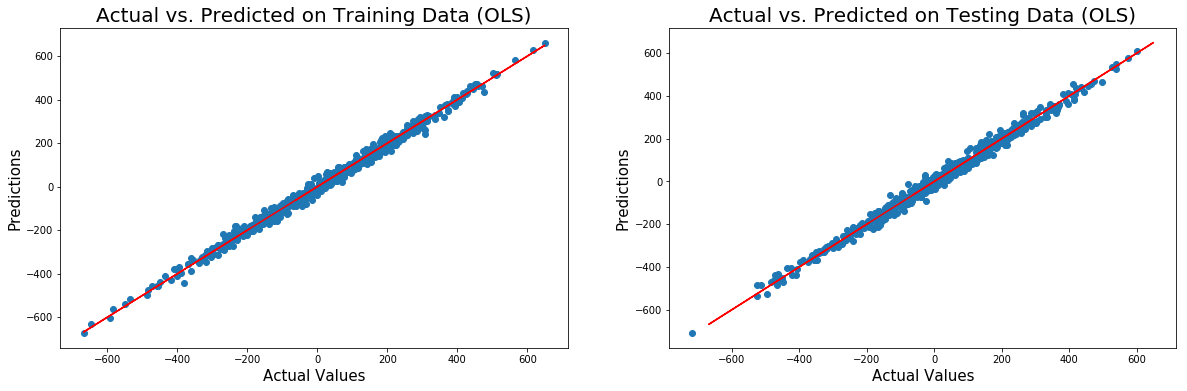

In [7]:
from sklearn.linear_model import LinearRegression

ols_model = LinearRegression().fit(X_train, y_train)

y_hat_train_ols, y_hat_test_ols = ols_model.predict(X_train), ols_model.predict(X_test)

# sets the plot size to 20x8
plt.rcParams['figure.figsize'] = (20,20)

plt.subplot(323)
plt.scatter(y_train, y_hat_train_ols)
plt.title('Actual vs. Predicted on Training Data (OLS)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')

plt.subplot(324)
plt.scatter(y_test, y_hat_test_ols)
plt.title('Actual vs. Predicted on Testing Data (OLS)', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.plot(y_train, y_train, color='r')
plt.show;

In [12]:
print(f'Gradient Boosted Trees MSE on Testing Data: {np.mean((y_test - y_hat_test_tree)**2)}')
print(f'Gradient Boosted Ridge Regression MSE on Testing Data: {np.mean((y_test - y_hat_test_ridge)**2)}')
print(f'Ordinary Least Squares MSE on Testing Data: {np.mean((y_test - y_hat_test_ols)**2)}')

Gradient Boosted Trees MSE on Testing Data: 11562.102449212642
Gradient Boosted Ridge Regression MSE on Testing Data: 769.7737278126256
Ordinary Least Squares MSE on Testing Data: 433.8959640828043


The simple OLS linear model wins hands down. Let this be a reminder to always think carefully about your data and the data generating process that gives it its structure before throwing algorithms at problems. Or not, and go crazy. I can't compel you to do anything.

I hope this article has given you a better idea of what is going on under the hood of one of the most powerful machine learning techniques. Now you can think about what your computer is doing while you go get coffee and wait for your grid search to finish.